## Language Detection from Text
##### (Machine-Learning Text Classification Model)
> *Workflow:*
> * Load Data, split into train and test sets.
> * Preprocessing:
>   * **Text cleaning**: Remove unusual charactes, like special charactes (!@#%^&), delimiters (.,_-;''""), brackets, escape characters, extra spaces etc.
>   * **Text Vectorization**: Convert text data to numerical vectors. (I wil use **TfIdf** vectorization technique, but other methods like **Bag of Words** or **Word embedding** can also be used.)
>   * **Label Encoding**: Machine Learning models can not understand ***text labelled categories*** hence we **must** convert text labels to numerical values before feeding our data to a ML model.
> * Feeding processed data to a Machine Learning Model or '**Training**' (As we are dealing with text data, hence i will prefer using **Naive Bayes** over any other ML algorithm beacuse they are fast and very will suited for text data.) (We can also apply deep learning models using RNNs and LSTMs in future)
> * **Test** the model accuracy using Test data (created during train-test-split).
> * Use the trained model to predict language from user inputs.


In [1]:
# basic libraries
import os
import re
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# model building tools
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


## Load and Generate required data

In [2]:
# set directories
input_dir = '/kaggle/input/'
working_dir = '/kaggle/working/'

In [3]:
data = pd.read_csv(f'{input_dir}language-identification-datasst/dataset.csv')
data.columns = ('text','language')
data

,text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


In [4]:
# train test split:
x_train, x_test, y_train, y_test = train_test_split(data.text.values, data.language.values,
                                                    test_size=0.1, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19800,), (19800,), (2200,), (2200,))

## EDA and Visualization (Exploring the dataset)

### Category wise Data Distribution

In [5]:
# number of texts for each language:
print(f"Number of languages: {len(data.language.value_counts())}\n")
print(f"Number of data points of individual languages:\n{data.language.value_counts()}")

Number of languages: 22

Number of data points of individual languages:
Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: language, dtype: int64


***Inference:*** Our dataset is completely balanced, as it contains equal data instances for each category

### Sentence length distribution

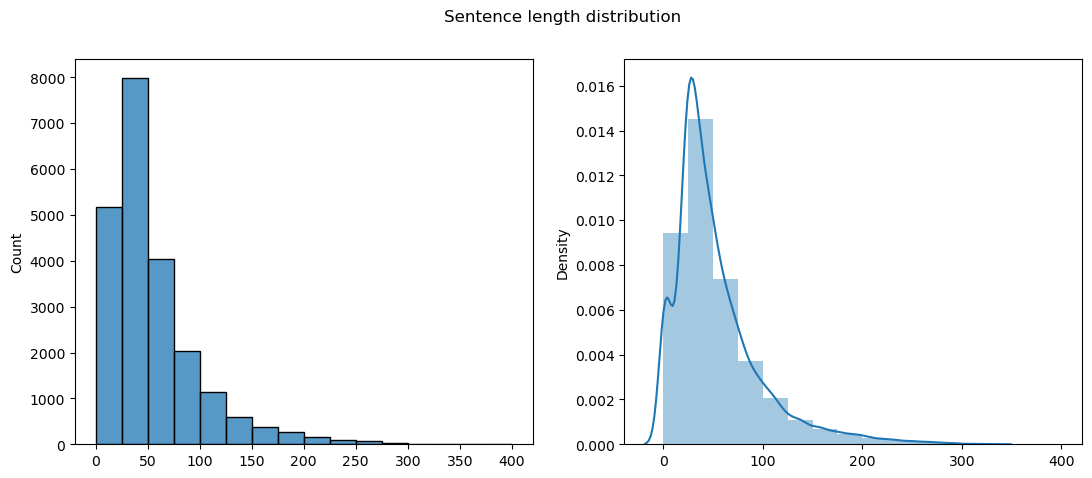

In [6]:
# sentence length distribution over the entire dataset
sent_lengths = [len(text.split()) for text in data.text.values]
plt.subplots(1,2,figsize=(13,5))
plt.suptitle('Sentence length distribution')
bins=[0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400]
plt.subplot(1,2,1)
sns.histplot(sent_lengths, bins=bins)
plt.subplot(1,2,2)
sns.distplot(sent_lengths, bins=bins)
plt.show()

***Inference:*** Majority of text sentences in our dataset has less than 50 words

### Language-wise Wordcloud

In [7]:
languages = np.unique(data.language.values).tolist()

plt.subplots(5,5,figsize=(100,100))
i=1
for lang in languages:
    text = data.text.loc[data.language==lang].values
    text = ' '.join(text)
    cloud = WordCloud(max_words=200, width=400, height=400, background_color='white').generate(text)
    plt.subplot(5,5,i)
    plt.imshow(cloud)
    plt.axis("off")
    plt.title(lang,fontsize=100)
    i+=1

looks awesome!

(**Note**: We currently can't see words from different scripts because, python current doesn't have their respective **font(.ttf)** file, we can manually import **.ttf** files either locally or from internet, by placing file path in **file_path** attribute in **wordcloud** function)

## Preprocessing

### Text Cleaning and Vectorization

In [8]:
# function to clean text
def clean_txt(text):
    text=text.lower()
    text=re.sub(r'[^\w\s]',' ',text)
    text=re.sub(r'[_0-9]',' ',text)
    text=re.sub(r'\s\s+',' ',text)
    return text

# example
txt = 'my (&*(()))name %$#is harsh_priye'
print(clean_txt(txt))

my name is harsh priye


In [9]:
x_train = [clean_txt(text) for text in tqdm(x_train)]
x_test = [clean_txt(text) for text in tqdm(x_test)]

100%|██████████| 2200/2200 [00:00<00:00, 14877.66it/s]


In [10]:
# using Tfidf Vectorizer:
tfidf = TfidfVectorizer()
tfidf.fit(x_train)
x_train_ready = tfidf.transform(x_train)
x_test_ready = tfidf.transform(x_test)

x_train_ready,x_test_ready

(<19800x258038 sparse matrix of type '<class 'numpy.float64'>'
 	with 821408 stored elements in Compressed Sparse Row format>,
 <2200x258038 sparse matrix of type '<class 'numpy.float64'>'
 	with 72117 stored elements in Compressed Sparse Row format>)

### Label Encoding

In [11]:
enc = LabelEncoder()
enc.fit(y_train)
y_train_ready = enc.transform(y_train)
y_test_ready = enc.transform(y_test)

In [12]:
# storing encoded label hast list as 'labels'
labels = enc.classes_
# display first 10 labels:
labels[:10]

array(['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French',
       'Hindi', 'Indonesian', 'Japanese', 'Korean'], dtype=object)

In [13]:
# checking if encoder is working properly
preds = enc.inverse_transform([0,2,5])
preds

array(['Arabic', 'Dutch', 'French'], dtype=object)

## Machine Learning
Model used: **Naive Bayes**


In [14]:
nb = MultinomialNB()
nb.fit(x_train_ready,y_train_ready)

MultinomialNB()

In [15]:
nb_score = nb.score(x_test_ready,y_test_ready)
print(nb_score)

0.9413636363636364


## Create Model Pipeline

In [16]:
# use pipeline to combine prefitted vectorizer and trained model into one object
model = Pipeline([('vectorizer',tfidf),('nb',nb)])

In [17]:
# save the model:
pickle.dump(model,open('/kaggle/working/model_v1.pkl','wb'))
# save the encoder
pickle.dump(enc,open('/kaggle/working/encoder.pkl','wb'))

## Checking our model on user fed data

In [18]:
# function to predict language from text
def predict(text):
    pred = model.predict([clean_txt(text)])
    ans = enc.inverse_transform(pred)
    return ans[0]

In [19]:
predict('my name is harsh'), predict('मेरा नाम हर्ष हे'), predict('mi nombre es harsh'), predict('меня зовут Харш'), predict('mon nom est harsh')

('English', 'Hindi', 'Spanish', 'Russian', 'French')

**Awesome results!**